In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [2]:
# Definir rutas
train_dir = '../data/train'
valid_dir = '../data/valid'
test_dir = '../data/test'

# Parámetros
img_height, img_width = 244, 244  # Tamaño de entrada (puedes ajustarlo)
batch_size = 32

# Aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Sólo reescalar para validación y prueba
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Para evaluar correctamente
)


Found 1120 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


In [3]:
# Inicializar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Tercera capa convolucional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Cuarta capa convolucional
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Aplanar las características
model.add(Flatten())

# Capa densa completamente conectada
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Regularización para prevenir sobreajuste

# Capa de salida
model.add(Dense(train_generator.num_classes, activation='softmax'))


c:\Users\emman\OneDrive\Escritorio\Banana-Disease-Clasification-with-Artificial-Intelligence\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 242, 242, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 242, 242, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 119, 119, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 119, 119, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 57, 57, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 57, 57, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,137,668 (393.44 MB)

 Trainable params: 103,135,748 (393.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [5]:
from PIL import Image  # Ensure Pillow is imported

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,  # Puedes ajustar el número de épocas
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
)


c:\Users\emman\OneDrive\Escritorio\Banana-Disease-Clasification-with-Artificial-Intelligence\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.5550 - loss: 2.1119 - val_accuracy: 0.2500 - val_loss: 4.5512
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50


C:\Users\emman\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


35/35 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.7353 - loss: 0.8052 - val_accuracy: 0.2500 - val_loss: 5.4819
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.7687 - loss: 0.6814 - val_accuracy: 0.2500 - val_loss: 5.8683
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.8095 - loss: 0.5254 - val_accuracy: 0.2500 - val_loss: 7.7463
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.8262 - loss: 0.5425 - val_accuracy: 0.2500 - val_loss: 8.1457
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.7988 - loss: 0.6455 - val_accuracy: 0.2500 - val_loss: 8.5444


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9640 - loss: 0.1211
Precisión en el conjunto de prueba: 94.69%


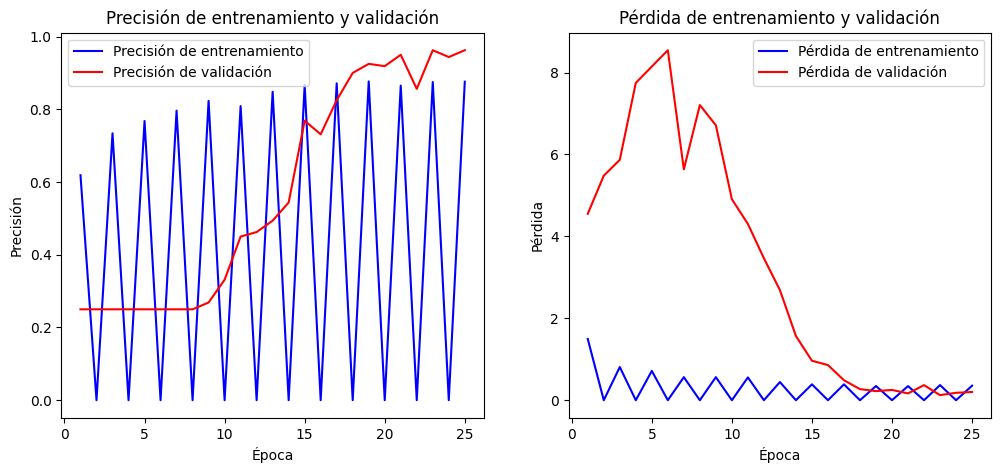

In [6]:
# Evaluar en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Precisión en el conjunto de prueba: {test_accuracy*100:.2f}%')

# Graficar las curvas de entrenamiento
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, min(len(acc), len(val_acc), len(loss), len(val_loss)) + 1)

    plt.figure(figsize=(12, 5))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc[:len(epochs)], 'b-', label='Precisión de entrenamiento')
    plt.plot(epochs, val_acc[:len(epochs)], 'r-', label='Precisión de validación')
    plt.title('Precisión de entrenamiento y validación')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss[:len(epochs)], 'b-', label='Pérdida de entrenamiento')
    plt.plot(epochs, val_loss[:len(epochs)], 'r-', label='Pérdida de validación')
    plt.title('Pérdida de entrenamiento y validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.show()

plot_history(history)


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 853ms/step


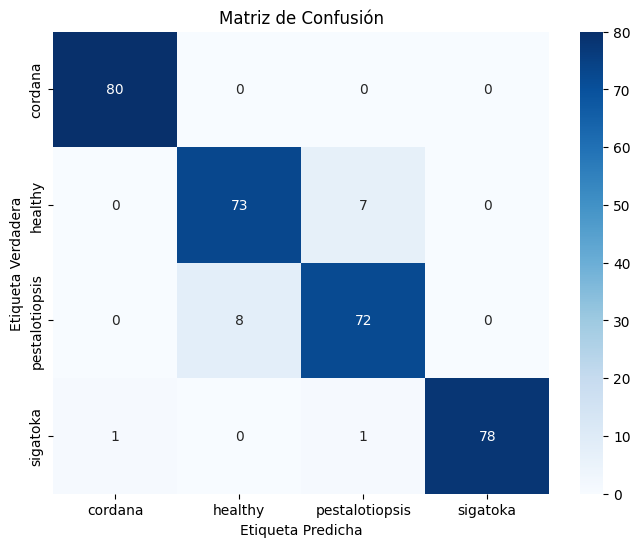

                precision    recall  f1-score   support

       cordana       0.99      1.00      0.99        80
       healthy       0.90      0.91      0.91        80
pestalotiopsis       0.90      0.90      0.90        80
      sigatoka       1.00      0.97      0.99        80

      accuracy                           0.95       320
     macro avg       0.95      0.95      0.95       320
  weighted avg       0.95      0.95      0.95       320



In [7]:
# Obtener las predicciones y etiquetas verdaderas
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes[:len(predicted_classes)]
class_labels = list(test_generator.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

# Informe de clasificación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


In [8]:
# Guardar el modelo
model.save('banana_leaf_disease_custom_cnn.h5')


In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Cargar el modelo
model = load_model('banana_leaf_disease_custom_cnn.h5')

# Función para predecir una imagen individual
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    return class_labels[predicted_class[0]]

# Ejemplo de uso
img_path = '../data/valid/sigatoka/5_aug.jpeg'
resultado = predict_image(img_path)
print(f'La imagen pertenece a la clase: {resultado}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
La imagen pertenece a la clase: sigatoka
